In [19]:
import numpy as np
import healpy as hp
import h5py
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import colors
import matplotlib.pyplot as plt

In [20]:
def data_fixing(data):
    '''
    Takes in GAIA csv file and removes all NaN values from the parallax column since without parallax, the distance cannot be calculated. Function also resets the indexing 
    of the dataframe to be continuous.
    '''
    global stars
    stars = pd.read_csv(data)

    nan_find = stars[stars['parallax'].isna()].index
    bad_dec = stars[stars['dec'] < -30].index

    stars = stars.drop(axis = 0, index = nan_find)
    stars = stars.drop(axis = 0, index = bad_dec)

    stars = stars.reset_index()
    del stars['index']
    
    return stars



In [21]:
def dist(table):
    '''
    Calculates the distance from the given parallax in the dataframe. The parallax is in milliarcseconds, so the distance is in parsecs. The distance values are then added to 
    the dataframe.
    '''
    
    distance = 1 / (table['parallax'].values / 1000) / 1000
    table['Distance (kpc)'] = distance

    return table


In [22]:
def equatorial_to_galactic(RA, DEC, table):
    '''
    Converts the right ascension and declination values into galactic 'l' and 'b' values which are then added onto the dataframe.
    '''    
    angle = SkyCoord(RA, DEC, frame = 'icrs', unit = 'deg')
    angle = angle.galactic

    table['l'] = angle.l.degree
    table['b'] = angle.b.degree

    low_lat = table[table['b'] < -60].index
    high_lat = table[table['b'] > 60].index

    table = table.drop(axis = 0, index = low_lat)
    table = table.drop(axis = 0, index = high_lat)

    return table


In [23]:
filename0="3D_temperature_9_dist_bins_nside_128.hdf5"
filename1="3D_temperature_17_dist_bins_nside_128.hdf5"

In [24]:
def load_3D_temperature_data(file):
    data_dict = {}
    with h5py.File(file, "r") as g:    
        data_dict["temperatures"]=g["temperature"][()] # this is (healpix x distance_bin)
        data_dict["distance_slices"] = g["distance_slices"][()]
        data_dict["nside"] = g.attrs["nside"]
        data_dict["nr_of_distance_bins"] = g.attrs["nr_of_distance_bins"]
        data_dict["healpix_ordering"] = g.attrs["healpix_ordering"] #nest
        g.close()
    return data_dict

In [25]:
def plot_3D_temperature_slice_maps(data_dict, fixed_file):
    Ts = data_dict["temperatures"]
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]

    for ds_index in range(model_nslices):                             
        hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
        if ds_index == 0: #checks for the first distance slice since the index cannot be -1
            find_stars = np.where(fixed_file['Distance (kpc)'] < model_dist_slices[ds_index]) #Finds the stars that are within the distance slice
            hp.visufunc.projscatter(fixed_file['l'].iloc[find_stars], fixed_file['b'].iloc[find_stars], lonlat = True, s = 1, c = 'white', alpha = 1)
                #Plots the stars onto the mollview map. 's' controls the size of the points plotted, and alpha conrols the transparency of the points plotted. 
                #Stars are plotted in white, colour is controlled by the c parameter
        else:
            find_stars = np.where((fixed_file['Distance (kpc)'] > model_dist_slices[ds_index - 1]) & (fixed_file['Distance (kpc)'] < model_dist_slices[ds_index]))
                #Finds the stars that are between distance slices
            hp.visufunc.projscatter(fixed_file['l'].iloc[find_stars], fixed_file['b'].iloc[find_stars], lonlat = True, s = 1, c= 'white', alpha = 1)
                #Plots the stars onto the mollview map. 's' controls the size of the points plotted, and alpha conrols the transparency of the points plotted.
                #Stars are plotted in white, colour is controlled by the c parameter
        plt.show()

In [26]:
data_dict0=load_3D_temperature_data(filename0)
data_dict1=load_3D_temperature_data(filename1)

In [27]:
big_data = data_fixing('big_data.csv') #Contains 788 stars within a box 115 < RA < 170 and 25 < DEC < 110. Limits for teff_gspphot are between 25000 and 50000, parallax >=0
                                       #declination >= -30, and galactic latitude bewteen -60 and 60.


In [28]:
big_data = dist(big_data)

In [29]:
big_data = equatorial_to_galactic(big_data['ra'].values, big_data['dec'].values, big_data)


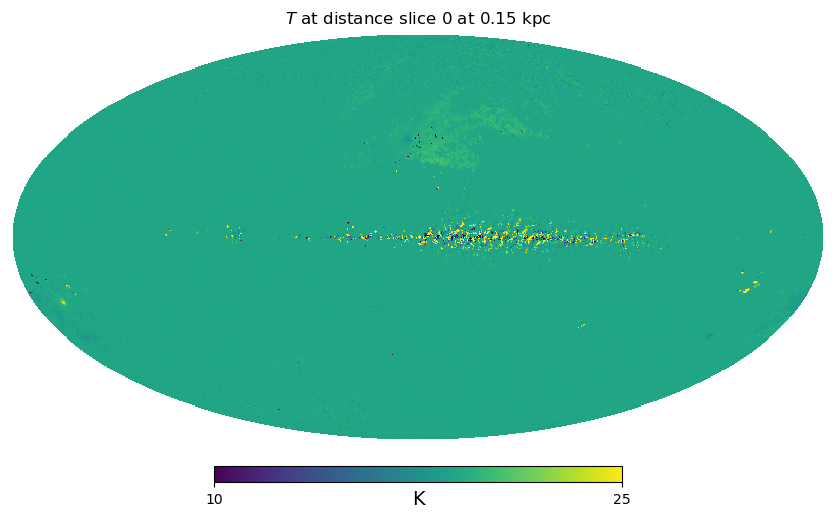

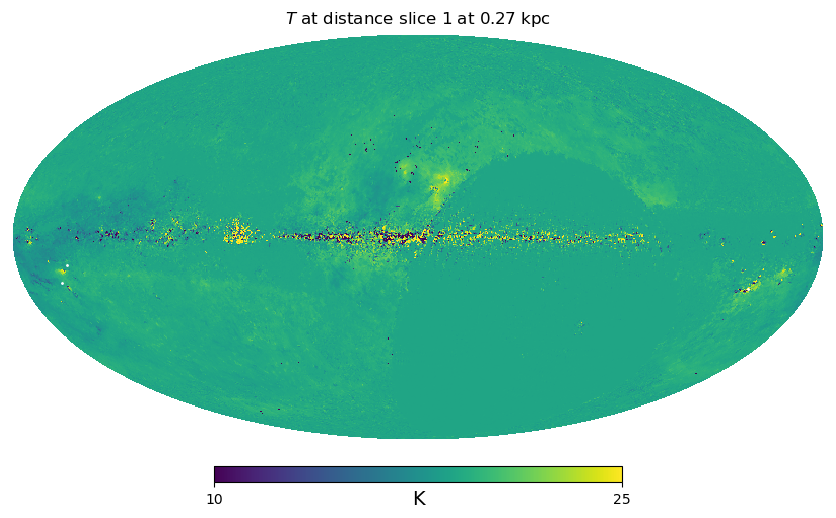

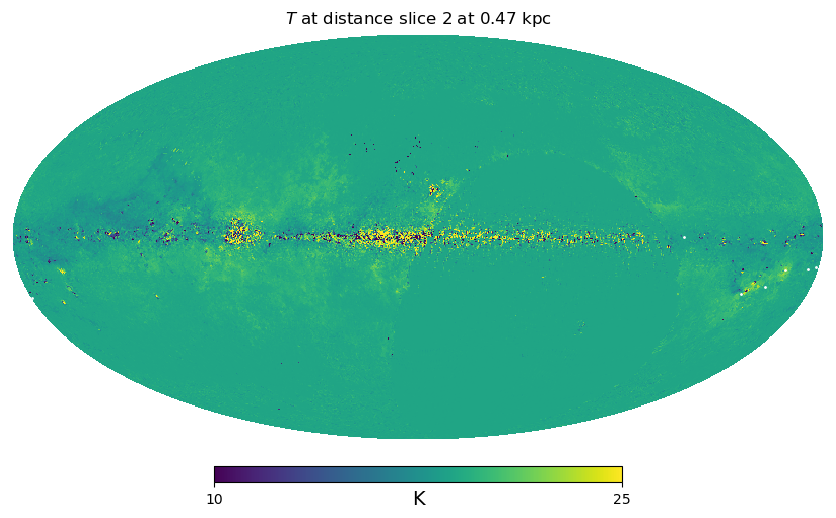

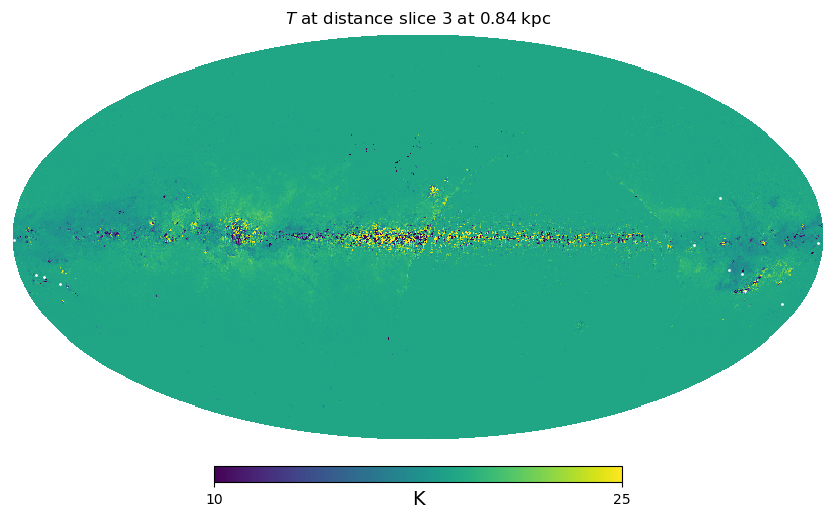

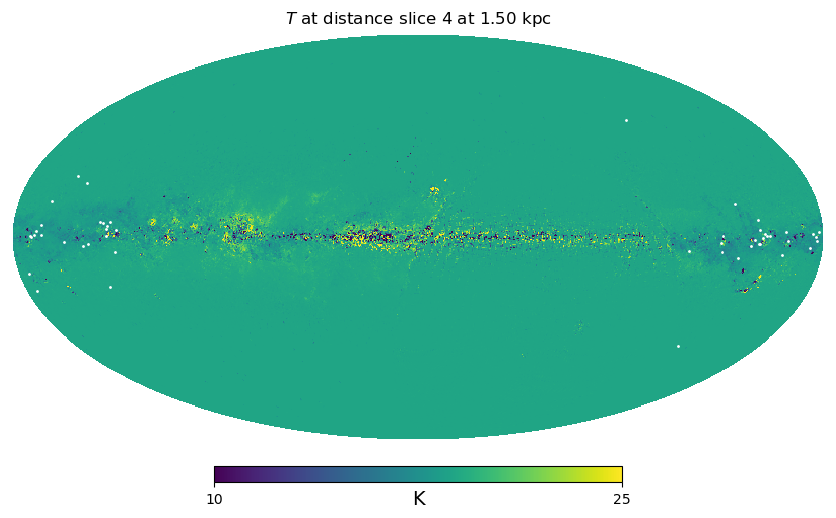

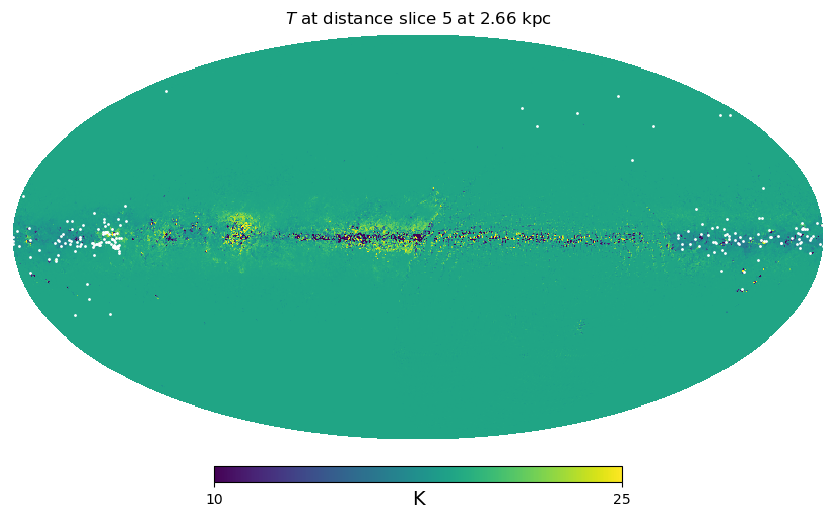

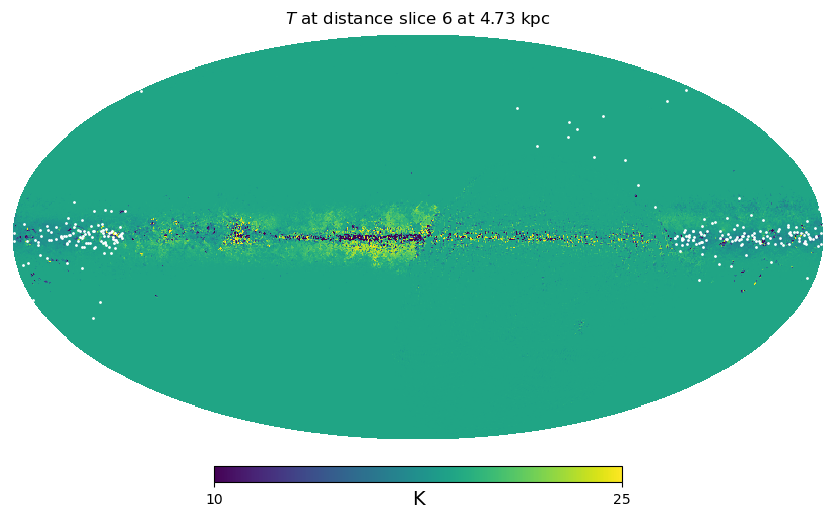

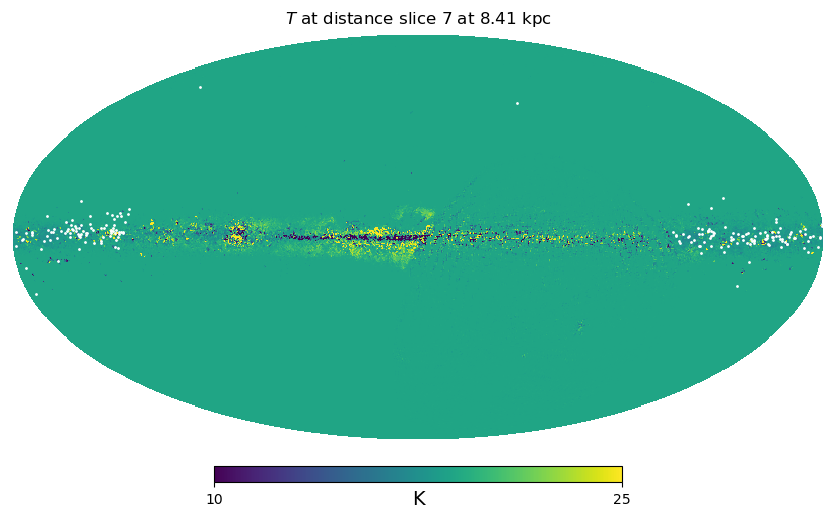

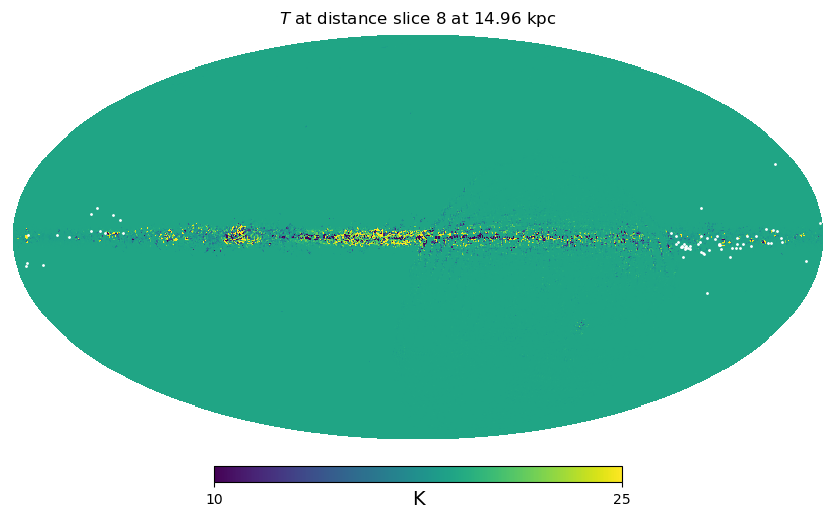

In [30]:
plot_3D_temperature_slice_maps(data_dict0, big_data)

In [ ]:
plot_3D_temperature_slice_maps(data_dict1, big_data)